<a href="https://colab.research.google.com/github/43pratik/Final_year_Project/blob/main/Fi_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#we mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#To check whether the drive is connect or not
!ls "/content/drive/MyDrive/Colab Notebooks/ECG_1"


abnormal  normal


In [7]:
#It split in dataset into training and testing
import os, shutil, random

def split_and_copy(source, train_target, test_target, split_ratio=0.8):
    files = [f for f in os.listdir(source) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)
    split = int(len(files) * split_ratio)

    os.makedirs(train_target, exist_ok=True)
    os.makedirs(test_target, exist_ok=True)

    for f in files[:split]:
        shutil.copy(os.path.join(source, f), os.path.join(train_target, f))
    for f in files[split:]:
        shutil.copy(os.path.join(source, f), os.path.join(test_target, f))


#  path of the dataset and path were we are saving the training and testing dataset
base_path = '/content/drive/MyDrive/Colab Notebooks/ECG_1'         # our actual folder in Drive
output_base = '/content/ECG_Classification'         # Local working directory in Colab

# Normal ECG
split_and_copy(
    source=f'{base_path}/normal',
    train_target=f'{output_base}/train/normal',
    test_target=f'{output_base}/test/normal'
)

# Abnormal ECG
split_and_copy(
    source=f'{base_path}/abnormal',
    train_target=f'{output_base}/train/abnormal',
    test_target=f'{output_base}/test/abnormal'
)


In [8]:
#import libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [30]:
print(train_generator.class_indices)

{'abnormal': 0, 'normal': 1}


Found 424 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5547 - loss: 0.7192 - val_accuracy: 0.8318 - val_loss: 0.5142
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7546 - loss: 0.5195 - val_accuracy: 0.8879 - val_loss: 0.4266
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.7988 - loss: 0.4506 - val_accuracy: 0.9159 - val_loss: 0.3802
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8620 - loss: 0.3825 - val_accuracy: 0.8598 - val_loss: 0.3658
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8611 - loss: 0.3633 - val_accuracy: 0.6542 - val_loss: 0.5522
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8954 - loss: 0.3214 - val_accuracy: 0.9065 - val_loss: 0.3023
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8639 - loss: 0.3408 - val_accuracy: 0.9439 - val_

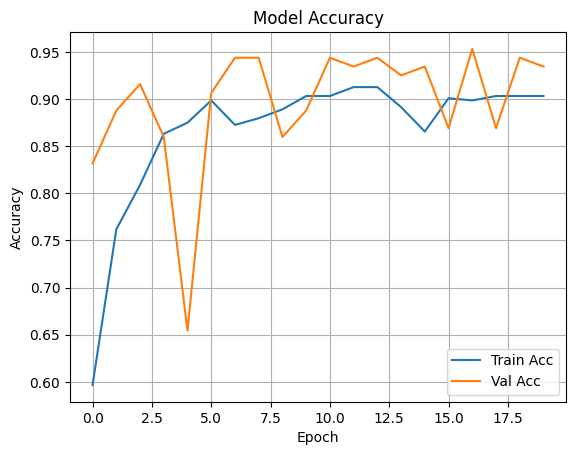

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set paths
train_dir = '/content/ECG_Classification/train'
test_dir = '/content/ECG_Classification/test'

# Image settings
img_height, img_width = 224, 224
batch_size = 32

# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Load MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base layers

# Build final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# we Add EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Plot training/validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
#here we test the model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Test image path
img_path = '/content/ECG_Classification/test/normal/Normal(109).jpg'

if os.path.exists(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)[0][0]


    if prediction >= 0.5:
        label = "normal"
        confidence = prediction
    else:
        label = "abnormal"
        confidence = 1 - prediction

    print(f"Prediction: {label} ({confidence * 100:.2f}% confidence)")

else:
    print(" Image path does not exist.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction: normal (78.03% confidence)


In [32]:
# Save entire model to a file
model.save('/content/ECG_CNN_Model.h5')

In [33]:
model.save('/content/drive/MyDrive/ECG_CNN_Model.h5')

In [ ]:
#To use the model again (in a new session, notebook)
from tensorflow.keras.models import load_model

# Load the saved model from local or Google Drive
model = load_model('/content/drive/MyDrive/ECG_CNN_Model.h5')
